In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import rasterio as rio
import geopandas as gpd
from rasterio.plot import show
import re
# from IPython.display import clear_output
import requests
import json
import math
import fiona
import richdem as rd
from shapely.geometry import *

In [2]:
project_path = os.path.abspath(os.path.join("readfiles.ipynb", os.pardir, os.pardir))
print("Found project in: ", project_path)
data_path = os.path.join(project_path, "Data")

external_data_path = "/media/seppe/DiskSpaceInvader/3DHouseData"

lookup_panda = pd.read_csv(os.path.join(project_path, "overviewdataframe.csv"))
lookup_panda.info()

Found project in:  /home/seppe/Projects/BeCode/3D-House-Project
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88064 entries, 0 to 88063
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   file_path     88064 non-null  object 
 1   id            88064 non-null  object 
 2   left_bound    88064 non-null  float64
 3   bottom_bound  88064 non-null  float64
 4   right_bound   88064 non-null  float64
 5   top_bound     88064 non-null  float64
 6   width_bound   88064 non-null  int64  
 7   height_bound  88064 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 5.4+ MB


In [48]:
class AddressError(Exception):
    pass

def address_lookup(addr:str, debug=False):
    req = requests.get(f"http://loc.geopunt.be/geolocation/location?q={addr}&c=1",)
    ret_dict = {}
    if req.json()["LocationResult"] == []:
        raise AddressError("That address couldn't be recognized, please try again with a different string.")
    for k,v in req.json()["LocationResult"][0].items():
        if debug: print(f"{k}: {v}")
        ret_dict[k] = [v]
    return ret_dict

my_address = address_lookup("kouter 1a leest", True)

Municipality: Mechelen
Zipcode: 2811
Thoroughfarename: Kouter
Housenumber: 1A
ID: 3159578
FormattedAddress: Kouter 1A, 2811 Mechelen
Location: {'Lat_WGS84': 51.03211343253992, 'Lon_WGS84': 4.4185522134848805, 'X_Lambert72': 153493.18, 'Y_Lambert72': 191326.86}
LocationType: crab_huisnummer_manueleAanduidingVanIngangVanGebouw
BoundingBox: {'LowerLeft': {'Lat_WGS84': 51.03211343253992, 'Lon_WGS84': 4.4185522134848805, 'X_Lambert72': 153493.18, 'Y_Lambert72': 191326.86}, 'UpperRight': {'Lat_WGS84': 51.03211343253992, 'Lon_WGS84': 4.4185522134848805, 'X_Lambert72': 153493.18, 'Y_Lambert72': 191326.86}}


Kouter 1A Mechelen 2811
[{'coordinates': [[[153512.49588567764, 191341.10419886187], [153508.31847767532, 191351.40883886814], [153501.52250967175, 191348.42682286724], [153501.19303767383, 191349.26131886616], [153496.4232456684, 191347.22099886462], [153495.85767766833, 191346.97907886654], [153485.95463766158, 191342.74279086292], [153477.92327765375, 191339.30727085844], [153478.09799765795, 191338.24442286044], [153471.05466965586, 191335.22541485727], [153475.3397256583, 191325.15642284974], [153473.15079765022, 191324.22535084933], [153474.67182165384, 191320.67642284557], [153476.8007176593, 191321.58240684867], [153479.38874965906, 191315.51034284383], [153491.5943176672, 191320.65568684787], [153491.57319766283, 191320.7020228468], [153490.0098696649, 191324.8798788488], [153489.6675336659, 191325.79475885257], [153490.7143176645, 191326.16391085088], [153491.69786966592, 191325.59328684956], [153493.04673366994, 191324.8109508492], [153494.89620567113, 191325.67315885052], [

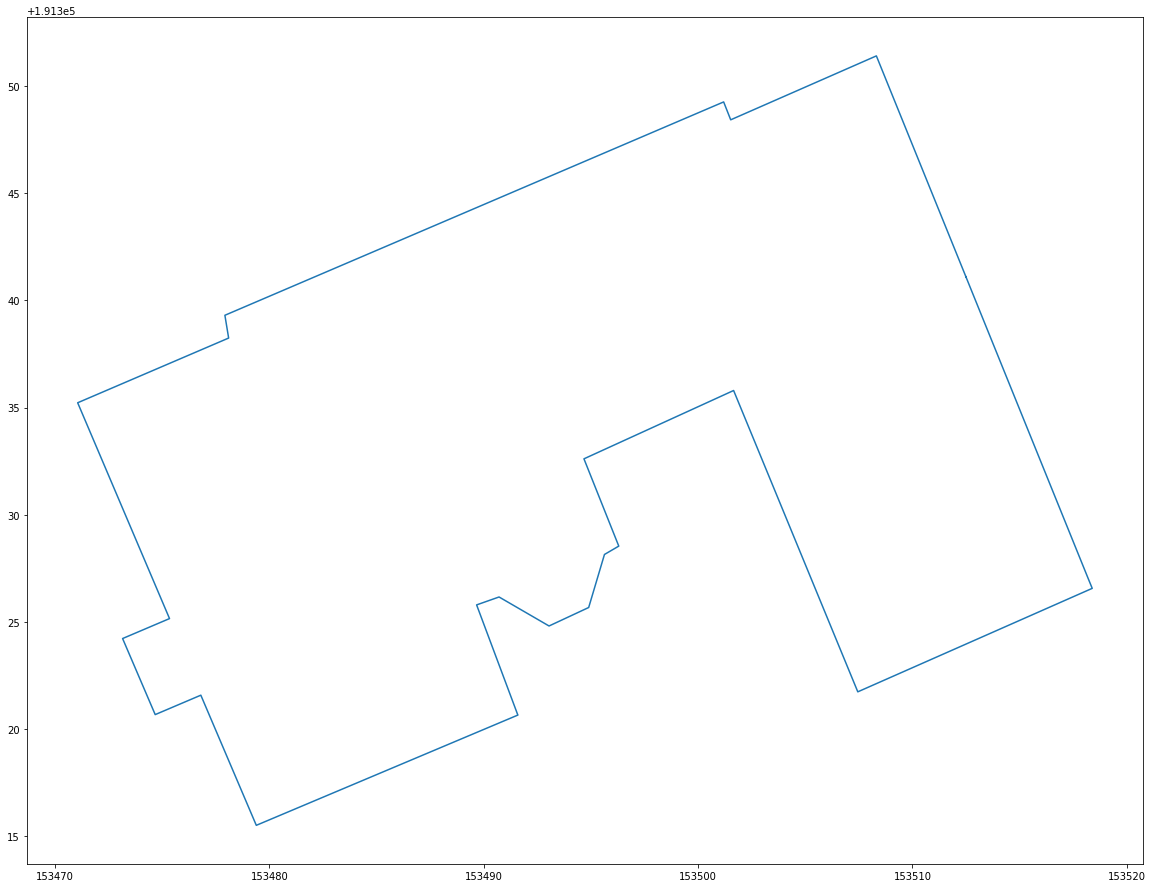

In [49]:
## Hedia's polygon API
def hedi_api(address:dict, debug=False):
    street = address['Thoroughfarename'][0]
    nb = address['Housenumber'][0]
    pc = address['Zipcode'][0]
    city = address['Municipality'][0]
    if debug: print(street,nb,city,pc)
    req = requests.get(f"https://api.basisregisters.dev-vlaanderen.be/v1/adresmatch?gemeentenaam={city}&straatnaam={street}&huisnummer={nb}&postcode={pc}").json()
    objectId = req["adresMatches"][0]["adresseerbareObjecten"][0]["objectId"]

    req = requests.get(f"https://api.basisregisters.dev-vlaanderen.be/v1/gebouweenheden/{objectId}").json()
    objectId = req["gebouw"]["objectId"]

    req = requests.get(f"https://api.basisregisters.dev-vlaanderen.be/v1/gebouwen/{objectId}").json()
    polygon = [req["geometriePolygoon"]["polygon"]]
    if debug: print(polygon)
    return polygon

def show_polygon(poly):
    for n in poly:
        loc = n['coordinates'][0]
        x,y = [],[]
        for i in range(len(loc)):
            x.append(loc[i][0])
            y.append(loc[i][1])
        fig, ax = plt.subplots(1, figsize=(20, 20))
        ax.set_aspect('equal')
        plt.plot(x, y, scalex=1, scaley=1)
        plt.show
    
my_poly = hedi_api(my_address, True)
show_polygon(my_poly)

153466.05466965586 191310.51034284383 153523.38919768482 191356.40883886814
Found LowerLeft
Found UpperRight
Found LowerLeft
Found UpperRight


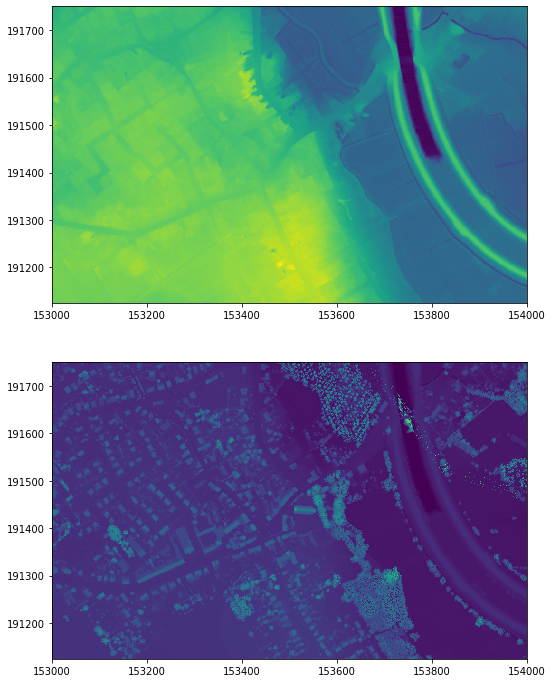

In [60]:
# a couple meters of freedom to add (or subtract) on all the bounds, 
# just to make sure the final result is visually pleasing, if there will ever be a final result o_o
margin = 5

def find_tiles(tile_panda, address_poly, debug=False):
    
    results = []
    
    # Weird loop to check the bounds of every polygon, 
    # assuming that there might be more polygon's for a single estate or something?
    for n in address_poly:
        points = n['coordinates'][0]

        left = points[0][0]
        bottom = points[0][1]
        right = points[0][0]
        top = points[0][1]

        for point in points:
            left = min(left, point[0])
            right = max(right, point[0])
            bottom = min(bottom, point[1])
            top = max(top, point[1])


        left -= margin
        bottom -= margin
        right += margin
        top += margin
        if debug: print(left, bottom, right, top)
        for row in tile_panda.itertuples():
            if row.left_bound < left < row.right_bound and row.bottom_bound < bottom < row.top_bound:
                if debug: print(f"Found LowerLeft")
                if row not in results:
                    results.append(row)
            if row.left_bound < right < row.right_bound and row.bottom_bound < top < row.top_bound:
                if debug: print(f"Found UpperRight")
                if row not in results:
                    results.append(row)
    if debug:
        fig, axes = plt.subplots(len(results),1, figsize=(12, 12))
        for i in range(len(results)):
            tif = results[i].file_path
            tif_im = rio.open(tif)
            show(tif_im, ax=axes[i])
        plt.show()
    # I will probably regret the decision to return this weird list later on. Too bad ...
    return (results, (left, bottom, right, top))
        
        
my_tifs = find_tiles(lookup_panda, my_poly, True)

466 185 476 393
[[8.02       7.2100005  5.5800004  ... 5.6200004  5.21       4.79      ]
 [8.59       7.99       7.5        ... 5.05       4.6000004  0.0999999 ]
 [9.23       8.530001   8.01       ... 4.4000006  0.         0.03999996]
 ...
 [3.8599997  4.96       4.88       ... 0.         0.         0.        ]
 [4.7700005  4.6900005  4.6500006  ... 0.         0.         0.        ]
 [4.5        4.450001   3.9000006  ... 0.         0.         0.        ]]


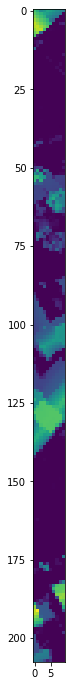

In [68]:
# TESTING GROUND, DANGER AHEAD, PROCEED WITH CAUTION


l = my_tifs[1][0]
b = my_tifs[1][1]
r = my_tifs[1][2]
t = my_tifs[1][3]
w = r-l
h = t-b

def manual_mask(tile_panda,tifs):
    with rio.open(tifs[0][0].file_path) as dtm: 
        with rio.open(tifs[0][1].file_path) as dsm:
            terrain_array = dtm.read()
            surface_array = dsm.read()
            chm_array = np.array(surface_array-terrain_array)
            l_dif = int(l-tifs[0][0].left_bound)
            b_dif = int(b-tifs[0][0].bottom_bound)
            r_dif = int(l_dif+w)
            t_dif = int(tifs[0][0].top_bound-t)
            print(l_dif, b_dif, r_dif, t_dif)
            fig, ax = plt.subplots(1, figsize=(12, 12))
            crop = chm_array[0][b_dif:t_dif, l_dif:r_dif]
            print(crop)
            show(crop, ax=ax)
            plt.show()

            
            
manual_mask(lookup_panda, my_tifs)

Looking for /media/seppe/DiskSpaceInvader/3DHouseData/DHMVIIDSMRAS1m_k15/DHMVII_vdc_k15.shp file in: /media/seppe/DiskSpaceInvader/3DHouseData/DHMVIIDSMRAS1m_k15
Found.


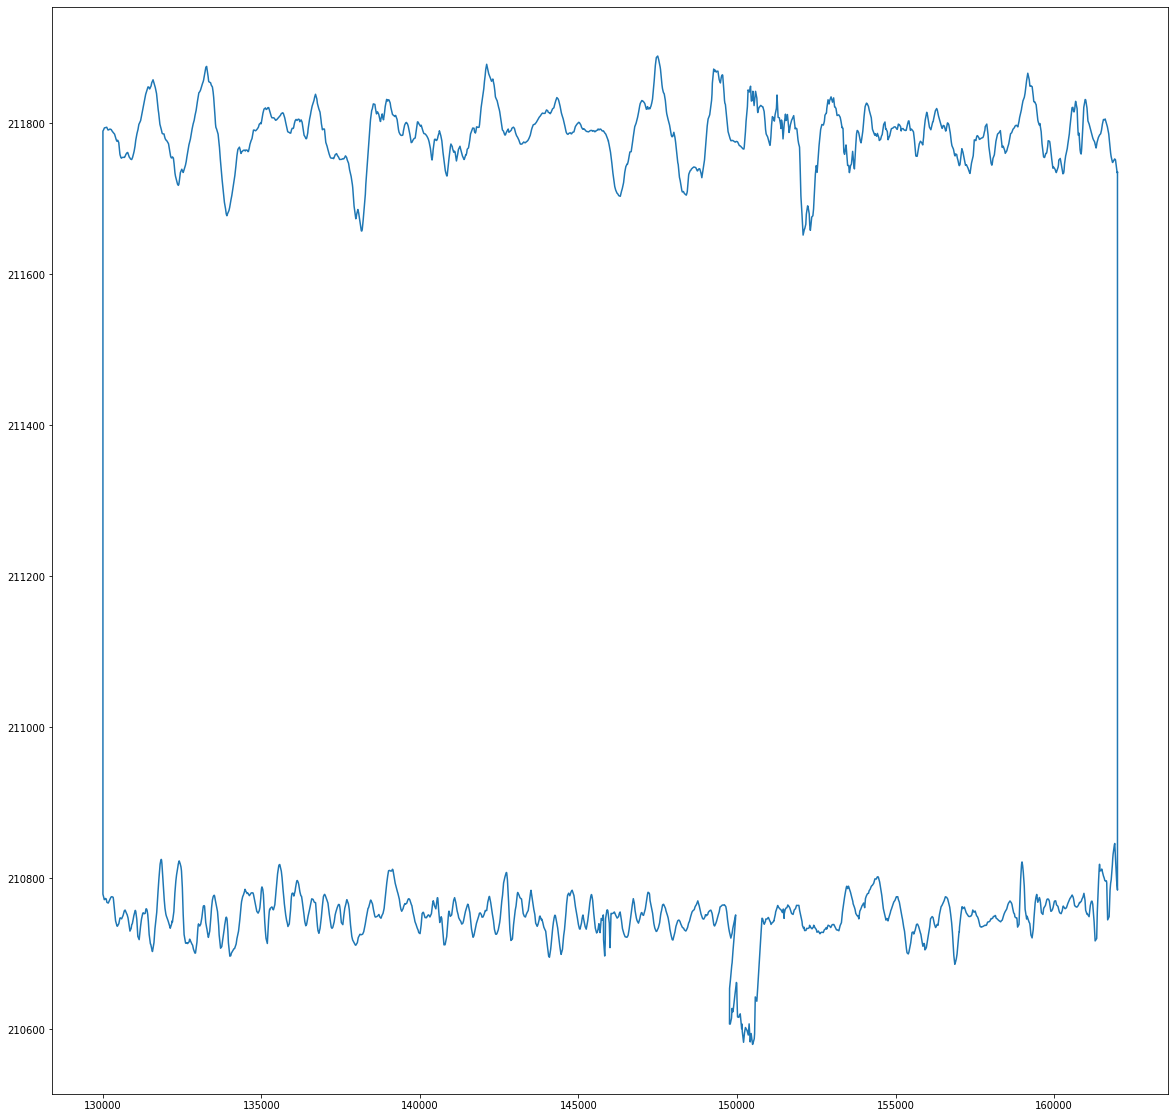

In [93]:
import zipfile
import time

def get_shape_file(tif_path, debug=False):
    geotif_folder = os.path.split(tif_path)[0]
    dsm_folder = os.path.split(geotif_folder)[0]
    k_number = dsm_folder[-3:]
    shape_name = f"DHMVII_vdc_{k_number}.shp"
    shape_path = os.path.join(dsm_folder, shape_name)
    if debug: print(f"Looking for {shape_path} file in: {dsm_folder}")
    if os.path.exists(shape_path):
        if debug: print("Found.")
        return shape_path
    else:
        if debug: print("Not found.")
        zip_path = os.path.join(dsm_folder, f"DHMVII_vdc_{k_number}.zip")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(dsm_folder)
        if debug: print("Extracting zip ...")
        time.sleep(1)
        return shape_path
    
shp = get_shape_file("/media/seppe/DiskSpaceInvader/3DHouseData/DHMVIIDSMRAS1m_k15/GeoTIFF/DHMVIIDSMRAS1m_k15_1_2_1_1_0.tif", True)

with fiona.open(shp, "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]
    fig, ax = plt.subplots(1, figsize=(20, 20))
    arr = np.array(shapes[5]['coordinates'][0])
    x,y = [],[]
    for i in range(len(arr)):
        x.append(arr[i][0])
        y.append(arr[i][1])
    plt.plot(x, y)
    plt.show
        

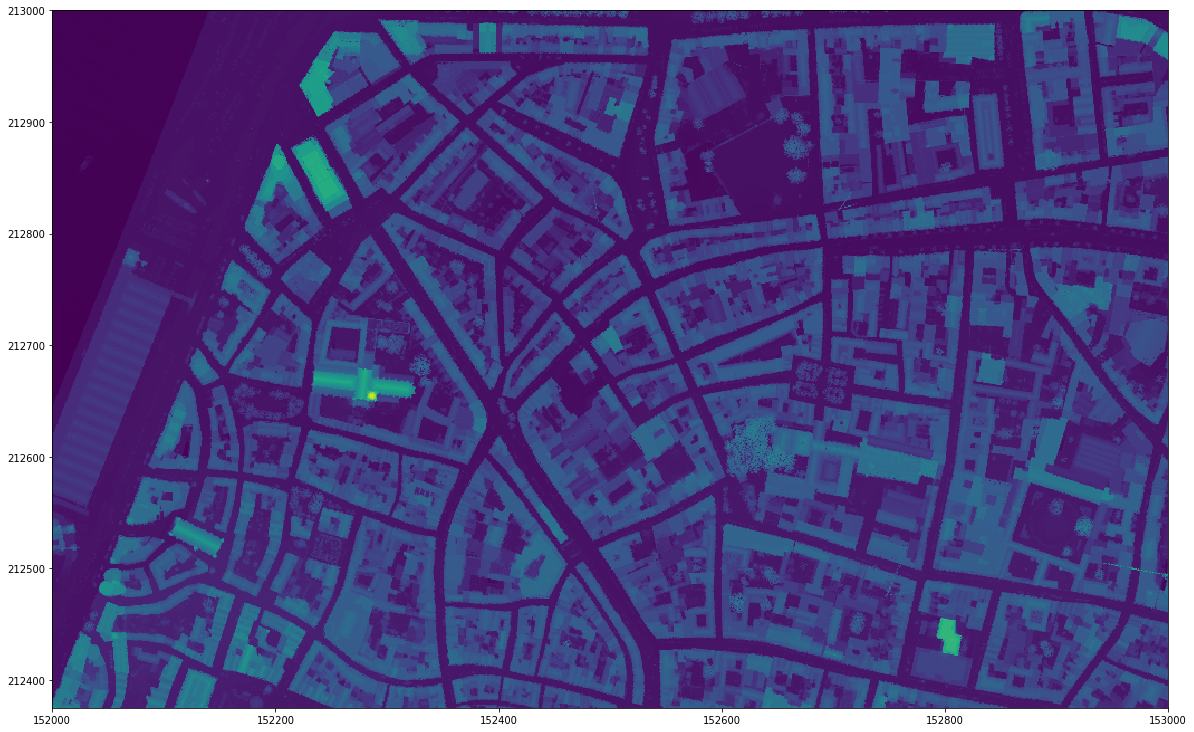

In [55]:
from rasterio import mask as riomask

tif = "/media/seppe/DiskSpaceInvader/3DHouseData/DHMVIIDSMRAS1m_k15/GeoTIFF/DHMVIIDSMRAS1m_k15_1_2_1_1_0.tif"
shp = get_shape_file(tif)

fig, ax = plt.subplots(1, figsize=(20, 20))
with fiona.open(shp, "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]
    with rio.open(tif) as src:
        out_image, out_transform = riomask.mask(src, shapes, crop=True)
        out_meta = src.meta
        out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform})
        with rio.open("masked.tif", "w", **out_meta) as dest:
            dest.write(out_image)
            
show(rio.open("masked.tif"))
plt.show()

In [ ]:
from rasterio.enums import Resampling

upscale_factor = 2

with rasterio.open("example.tif") as dataset:

    # resample data to target shape
    data = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )

    # scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )
    
data = rio.open(tile_dsmfile)

crop_img, crop_transform = mask(dataset=data, shapes=polygon, crop=True, indexes=1, nodata=0, filled=True)
print(crop_img)

fig = go.Figure(data=[go.Surface(z=crop_img)])

fig.update_layout(title='3D Plot', autosize=True)

fig.show()